In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import KFold
from copy import deepcopy
from scipy.stats import pearsonr
from pathlib import Path
import numpy.fft as fft
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as patches
import colorcet as cc

#my addtion to automate inputs and outputs
import helper_functions as hf
figfolder = '../hwfigures/'


In [2]:
root_dir = '../data/'
nctrains, nctest = hf.load_data_from_nc(root_dir)

var_input_names = ['ssh_ins', 'T_xy_ins', 'u_xy_ins', 'v_xy_ins']
var_output_names = ['ssh_cos', 'ssh_sin']

Nbase = 16
N_inp = len(var_input_names)
N_out = len(var_output_names)

vel_cmap  = cc.cm.CET_CBD1
TOTssh_cmap =  cc.cm.CET_D2
ITssh_cmap  = cc.cm.CET_D1A
sst_cmap = cc.cm.linear_bmy_10_95_c78
vort_cmap =  cc.cm.CET_D3

snap_index = 100

In [3]:
ytest_slice = slice(0, 720)
xtest_slice = slice(0, 256)
rectest_slice = slice(0, 150)
def loadtest():
    var_input = np.ones([150, N_inp, 720, 256])
    var_output = np.ones([150, N_out, 720, 256])

    for ind, var_name in enumerate(var_input_names):
        data_squeezed = np.squeeze(nctest.variables[var_name])
        var_input[:, ind, :, :] = data_squeezed[rectest_slice, ytest_slice, xtest_slice]
    for ind, var_name in enumerate(var_output_names):
        data_squeezed = np.squeeze(nctest.variables[var_name])
        var_output[:, ind, :, :] = data_squeezed[rectest_slice, ytest_slice, xtest_slice]
    return var_input, var_output

inp_test, out_test  = loadtest()
print(inp_test.shape)
print(out_test.shape)

(150, 4, 720, 256)
(150, 2, 720, 256)


[0, 1020, 0, 2876]


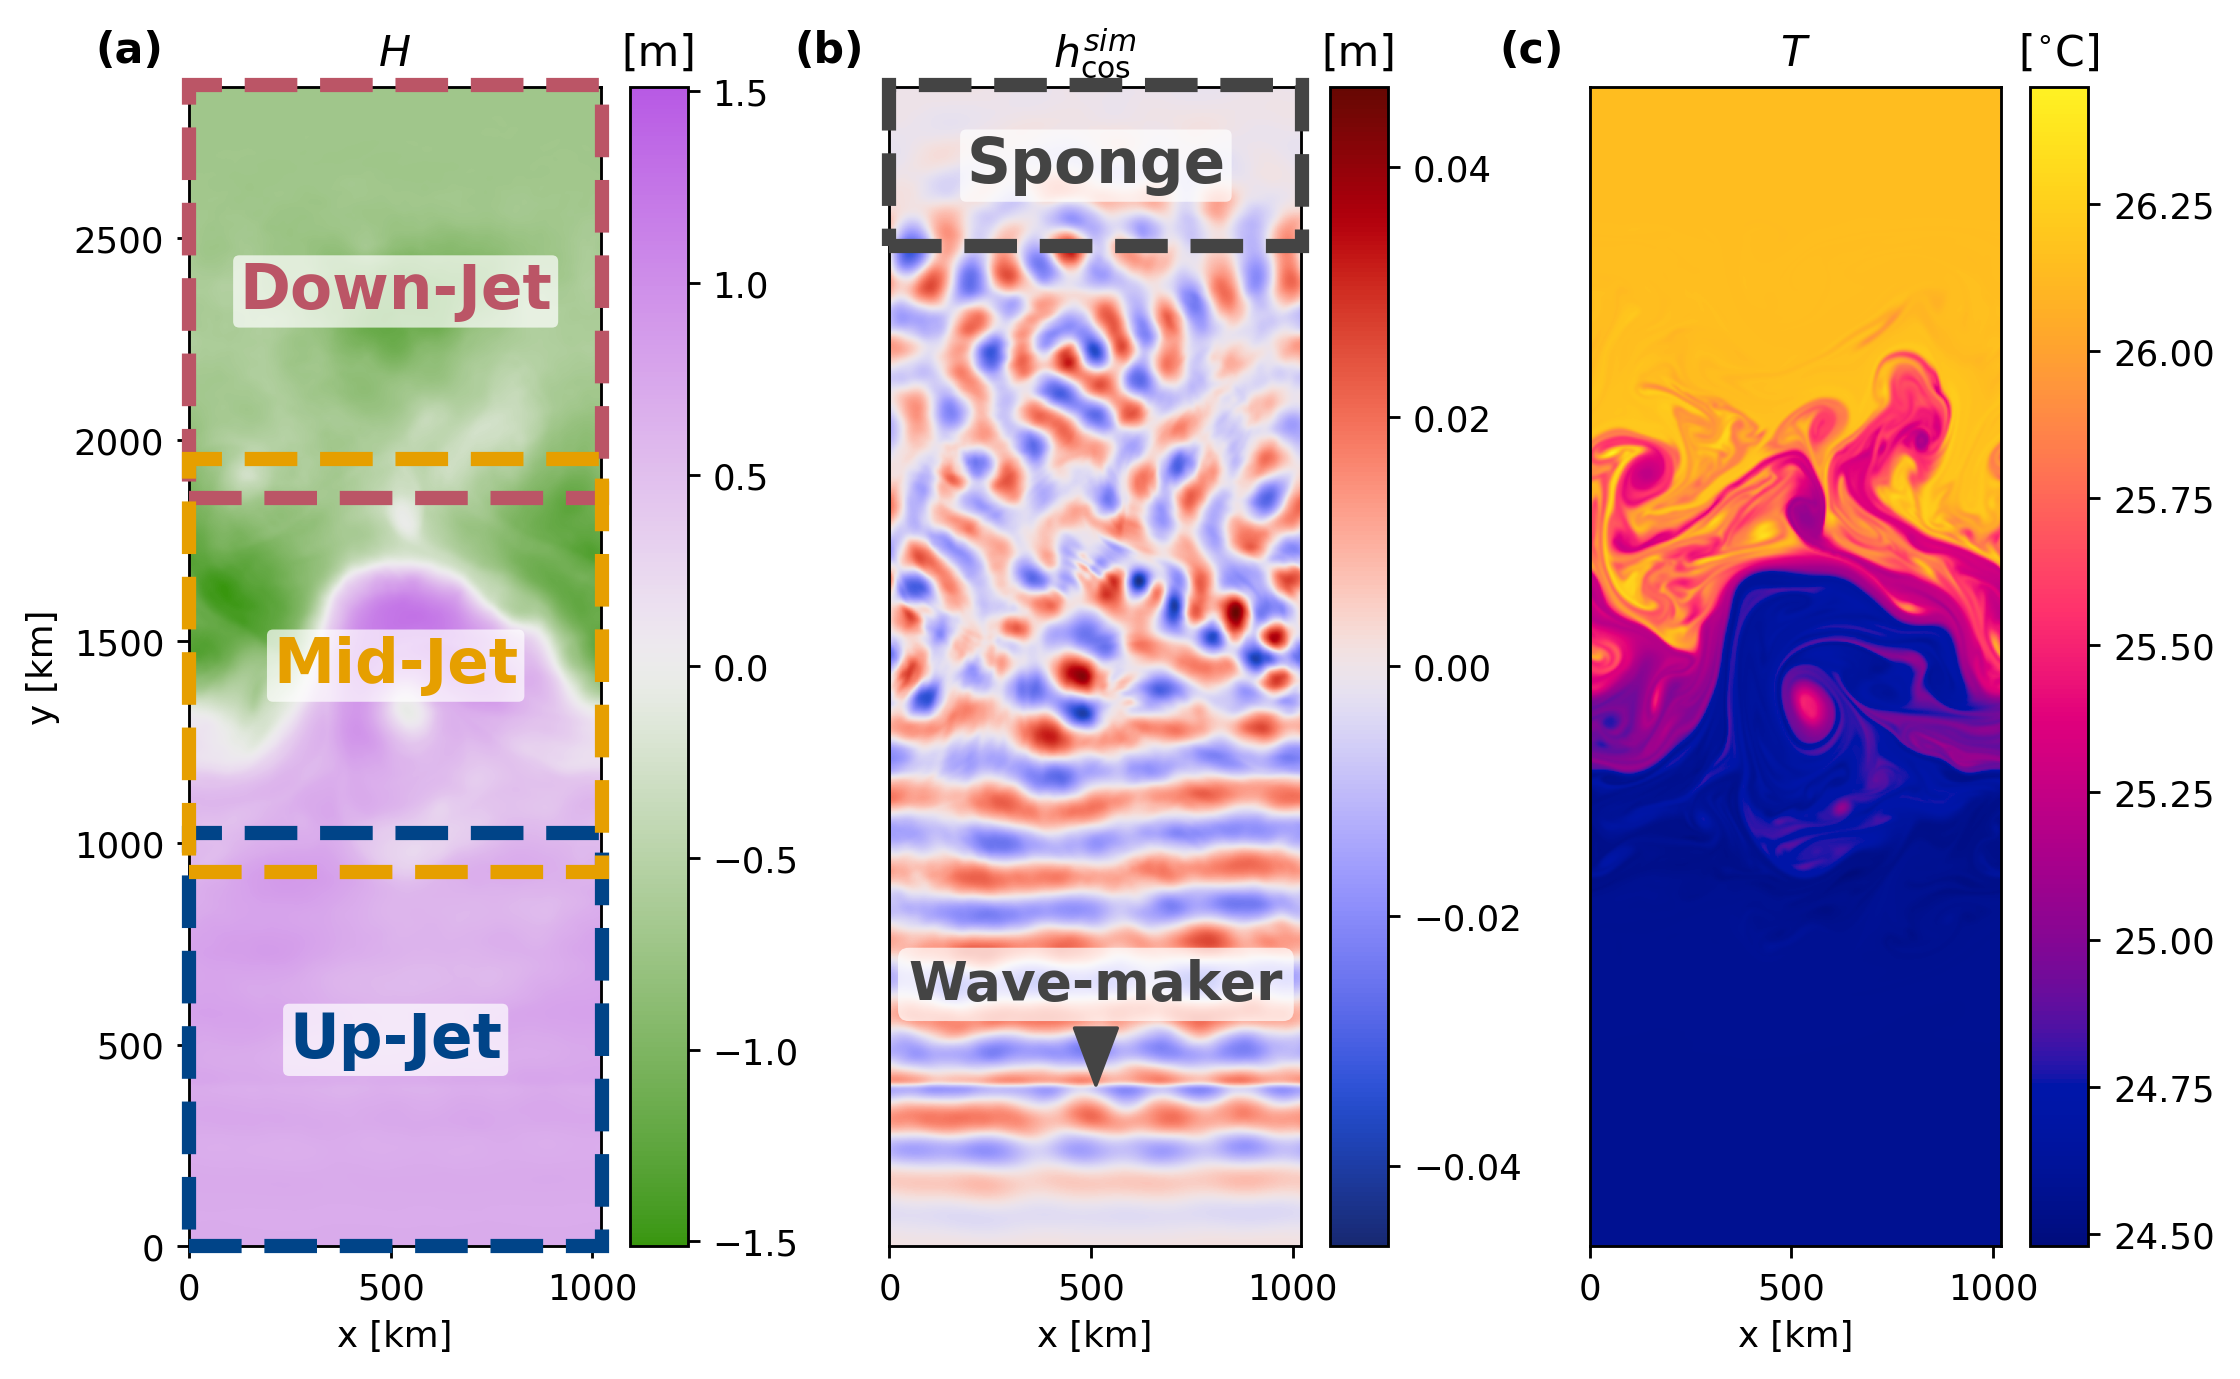

In [4]:
jetmarkercolors = ['#004488','#E69F00','#BB5566']
ind = snap_index
true_snap = out_test[ind,0, :, :]
bottom_slice = slice(0,256)
mid_slice = slice(232, 488)
top_slice = slice(464, 720)


inp_H_100 = inp_test[ind, 0, :, :]
inp_T_100 = inp_test[ind, 1, :, :]


ny, nx = np.shape(true_snap)
dx = 4
Lx = nx*dx
Ly = ny*dx
x_axis = np.arange(0, Lx, dx)
y_axis = np.arange(0, Ly, dx)
extent = [np.min(x_axis), np.max(x_axis), np.min(y_axis), np.max(y_axis)]
print (extent)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize = (10, 6),dpi = 256)

TOTsshm = np.max(np.abs(inp_H_100))
TOTclims = (-TOTsshm, TOTsshm)

im1 = ax1.imshow(inp_H_100, origin= 'lower', cmap=TOTssh_cmap, clim = TOTclims, extent = extent,zorder=0)


cb = fig.colorbar(im1, ax = ax1)
cb.ax.set_title(r'[m]', fontsize='large', pad=6)
ax1.set_xlabel('x [km]')
ax1.set_ylabel('y [km]')
bottom_panel = patches.Rectangle((0,0),256*dx, 256*dx, linewidth=4, edgecolor=jetmarkercolors[0], facecolor='none', linestyle='--', zorder=100, clip_on=False)
ax1.add_patch(bottom_panel)

mid_panel = patches.Rectangle((0,232*dx),256*dx, 256*dx, linewidth=4, edgecolor=jetmarkercolors[1], facecolor='none', linestyle='--', zorder=200, clip_on=False)
ax1.add_patch(mid_panel)

bottom_xc = 0 + (256*dx)/2
bottom_yc = 0 + (256*dx)/2
mid_xc = 0 + (256*dx)/2
mid_yc = 232*dx + (256*dx)/2
top_xc = 0 + (256*dx)/2
top_yc = 464*dx + (256*dx)/2
ax1.text(bottom_xc, bottom_yc, 'Up-Jet', fontsize='xx-large',fontweight='bold', c = jetmarkercolors[0], ha='center', va='center',bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'))
ax1.text(mid_xc, mid_yc, 'Mid-Jet', fontsize='xx-large',fontweight='bold', c = jetmarkercolors[1], ha='center', va='center',bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'))
ax1.text(top_xc, top_yc, 'Down-Jet', fontsize='xx-large',fontweight='bold', c = jetmarkercolors[2], ha='center', va='center',bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'))

top_panel = patches.Rectangle((0,464*dx),256*dx, 256*dx, linewidth=4, edgecolor=jetmarkercolors[2], facecolor='none', linestyle='--', zorder=100, clip_on=False)
ax1.add_patch(top_panel)
ax1.set_title(r'$H$')

# axoffset = 9*dx
# ax1.set_xlim(extent[0] - axoffset, extent[1] + axoffset)
# ax1.set_ylim(extent[2] - axoffset, extent[3] + axoffset)



ITsshm = np.max(np.abs(true_snap))
ITclims = (-ITsshm, ITsshm)

im2 = ax2.imshow(true_snap, origin= 'lower', cmap=ITssh_cmap, clim = ITclims, extent = extent)
cb = fig.colorbar(im2, ax = ax2)
cb.ax.set_title(r'[m]', fontsize='large', pad=6)

ax2.set_xlabel('x [km]')
ax2.set_title(r'$h^{sim}_{\cos}$')

ax2.set_yticks([])

#-------------------Mark wavemaker--------------------------------------
arrow_x = 256*dx/2         
arrow_y_start = 100*dx + 35     # just below the actual upper y-boundary
arrow_y_end = 100*dx            # points exactly at 100*dx

# Draw a vertical arrow, from (arrow_x, arrow_y_start) DOWN to (arrow_x, arrow_y_end)
ax2.annotate(
    '',                               # No text for the annotation arrow
    xy=(arrow_x, arrow_y_end),        # arrow tip
    xytext=(arrow_x, arrow_y_start),  # start of arrow
    arrowprops=dict(
        facecolor='#444444', 
        edgecolor='#444444',
        width=6,                # thickness of the shaft
        headwidth=12,           # width of the arrow head
        headlength=16,          # length of the arrow head
        shrink=0,
    ), 
    annotation_clip=False
)

# Place the text slightly above the arrow head
ax2.text(
    arrow_x, arrow_y_start+150,                        
    'Wave-maker',
    fontsize=15, fontweight='bold',
    c='#444444',
    rotation=0,
    va='bottom', ha='center',
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2', edgecolor='none')
)
#---------------------------------------------------------------------------
#---------------------Mark Sponge region------------------------------------
sponge_panel = patches.Rectangle(
    (0, 620*dx),                  # x, y (bottom left)
    256*dx,                       # width
    100*dx,                       # height (or adjust to match your region size)
    linewidth=4,
    edgecolor='#444444', # Same as Down-jet
    facecolor='none',
    linestyle='--',
    zorder=100,                   # match zorder as in subplot 1
    clip_on=False
)
ax2.add_patch(sponge_panel)

sponge_xc = 0 + (256*dx)/2
sponge_yc = 620*dx + (100*dx)/2   # center of the rectangle
ax2.text(
    sponge_xc, sponge_yc, "Sponge",
    fontsize='xx-large', fontweight='bold',
    c='#444444',
    ha='center', va='center',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1')
)
#--------------------------------------------------------------------------
 
im3 = ax3.imshow(inp_T_100, origin= 'lower', cmap=sst_cmap, extent = extent)
cb = fig.colorbar(im3, ax = ax3)
cb.ax.set_title(r'[$^{\circ}$C]', fontsize='large', pad=6)

# cb.set_label(r'$^{\circ}C$', size='large', labelpad=0, rotation=0)
ax3.set_xlabel('x [km]')
ax3.set_title(r'$T$')
ax3.set_yticks([])
# fig.tight_layout()

ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

#-------Add panel numbers-----------------
labels = ['(a)', '(b)', '(c)']
axs = [ax1, ax2, ax3]
for i, ax in enumerate(axs):
    # Get axes position in figure coordinates
    pos = ax.get_position()
    x = pos.x0  # left of axis in figure coordinates
    y = pos.y1  # top of axis in figure coordinates
    
    # Add text slightly to left and above the axes (offset = 0.01)
    fig.text(x - 0.01, y + 0.01, labels[i], fontsize='large', fontweight='bold', va='bottom', ha='right')
#------------------------------------------

fig.savefig(figfolder+'Bouss_setup2.png', bbox_inches='tight',dpi = 256)



In [5]:
# def vorticity(u, v):
#     #only works for snapshot
#     return np.gradient(v, axis =1) - np.gradient(u, axis =0)
# def divergence(u, v):
#     return np.gradient(u, axis =1) + np.gradient(v, axis =0)
dx=4000
def vorticity(u, v):
    #only works for snapshot
    return np.gradient(v, dx, axis =1) - np.gradient(u, dx, axis =0)
def divergence(u, v):
    return np.gradient(u, dx, axis =1) + np.gradient(v, dx, axis =0)



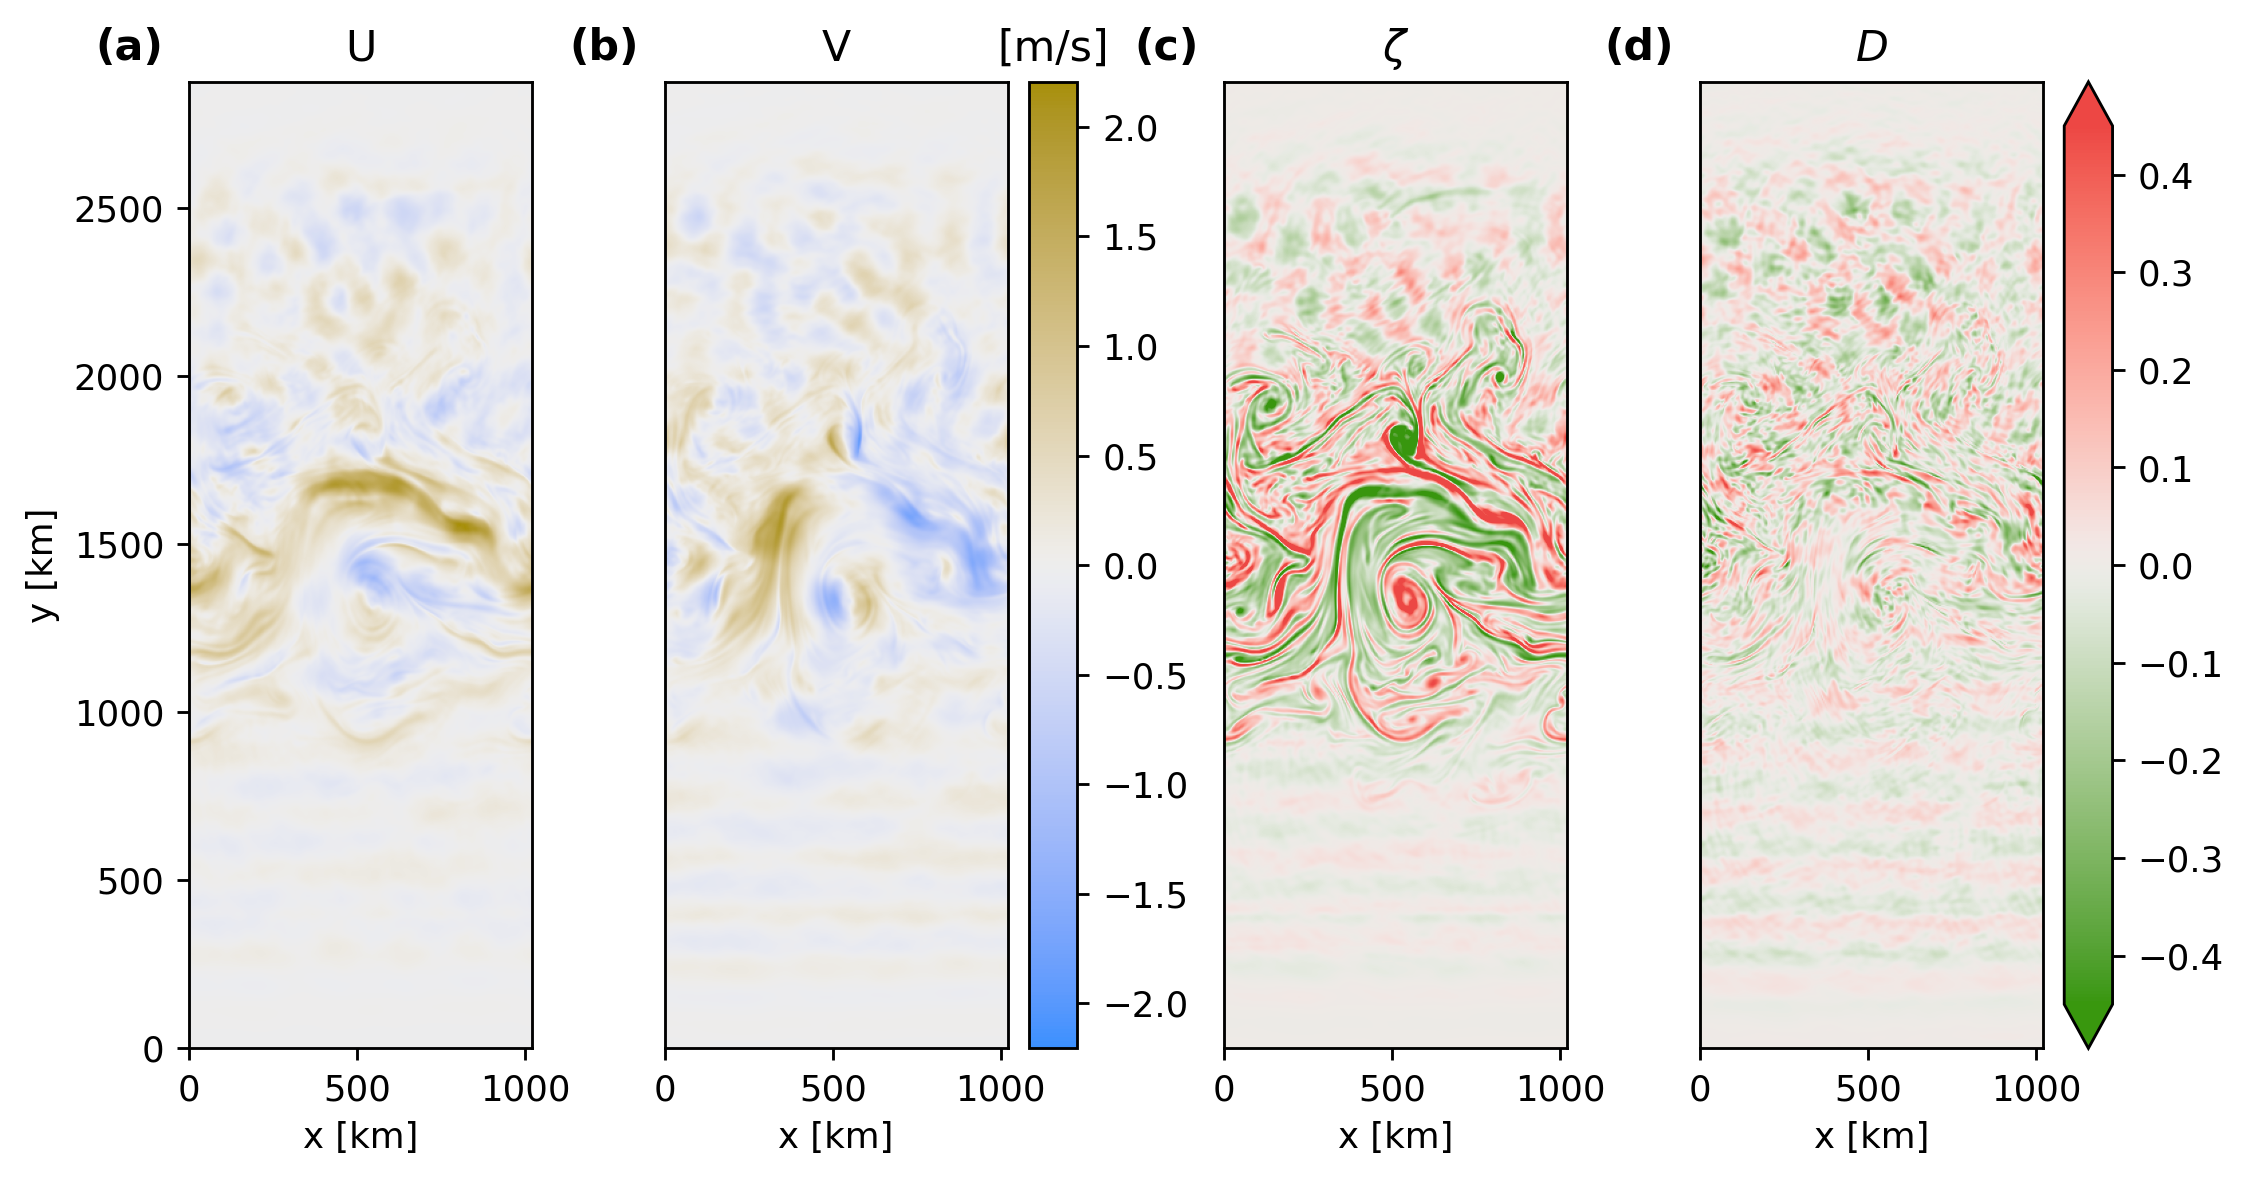

In [19]:
U = inp_test[ind, 2, :, :]
V = inp_test[ind, 3, :, :]
umag  = np.sqrt(U**2 + V**2)
vort_inp = vorticity(U, V)
div_inp = divergence(U, V)
f = 2*7.2921*10**(-5)*np.sin(45*np.pi/180) #at central latitude, 45N

vort_norm = TwoSlopeNorm(vcenter=0, vmin = -0.45, vmax = 0.45)
vel_norm = TwoSlopeNorm(vcenter=0, vmin = -1*np.max(np.abs([U, V])),vmax = np.max(np.abs([U, V])))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize = (10, 5),dpi = 256)

im1 = ax1.imshow(U, origin= 'lower', cmap=vel_cmap, extent = extent, norm =vel_norm)
# cb = fig.colorbar(im1, ax = ax1)
ax1.set_xlabel('x [km]')
ax1.set_ylabel('y [km]')
ax1.set_title('U')

im2 = ax2.imshow(V, origin= 'lower', cmap=vel_cmap, extent = extent, norm =vel_norm)
cb = fig.colorbar(im2, ax = ax2)
ax2.set_yticks([])
ax2.set_xlabel('x [km]')
ax2.set_title('V')
cb.ax.set_title(r'[m/s]', fontsize='large', pad=6)
im3 = ax3.imshow(vort_inp/f, origin= 'lower', cmap=vort_cmap, extent = extent, norm =vort_norm)
# cb = fig.colorbar(im3, ax = ax3)
ax3.set_yticks([])
ax3.set_xlabel('x [km]')
ax3.set_title(r'$\zeta$')

im4 = ax4.imshow(div_inp/f, origin= 'lower', cmap=vort_cmap, extent = extent, norm =vort_norm)
cb = fig.colorbar(im4, ax = ax4, extend='both')
ax4.set_yticks([])
ax4.set_xlabel('x [km]')
ax4.set_title(r'$D$')

ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

#-------Add panel numbers-----------------
labels = ['(a)', '(b)', '(c)','(d)']
axs = [ax1, ax2, ax3, ax4]
for i, ax in enumerate(axs):
    # Get axes position in figure coordinates
    pos = ax.get_position()
    x = pos.x0  # left of axis in figure coordinates
    y = pos.y1  # top of axis in figure coordinates
    
    # Add text slightly to left and above the axes (offset = 0.01)
    fig.text(x - 0.01, y + 0.01, labels[i], fontsize='large', fontweight='bold', va='bottom', ha='right')
#------------------------------------------


fig.savefig(figfolder+'Vel_Vort_input2.png', bbox_inches='tight',dpi = 256)


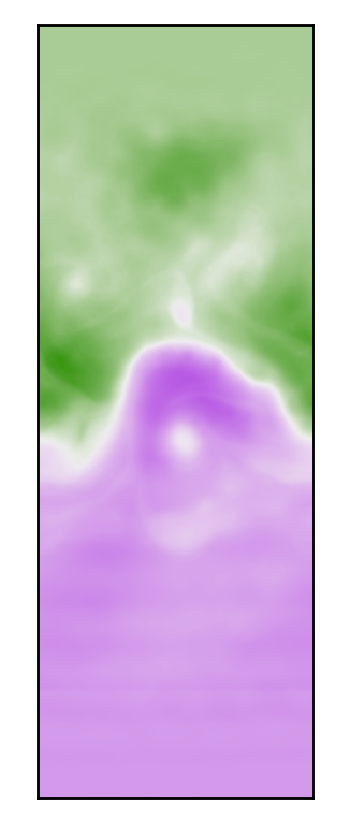

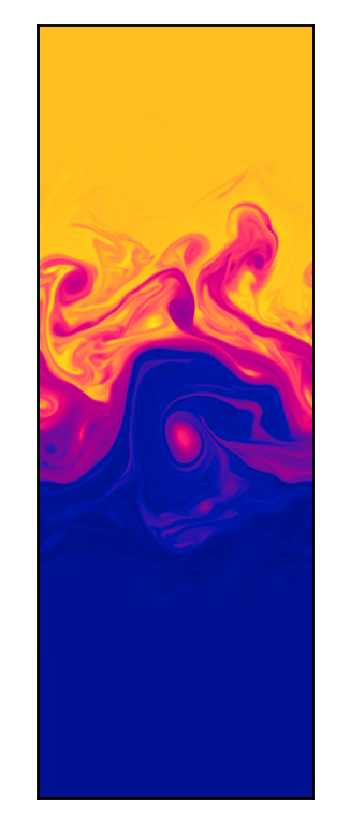

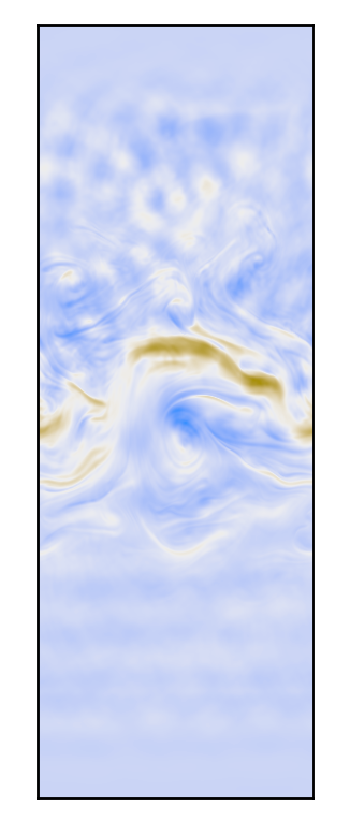

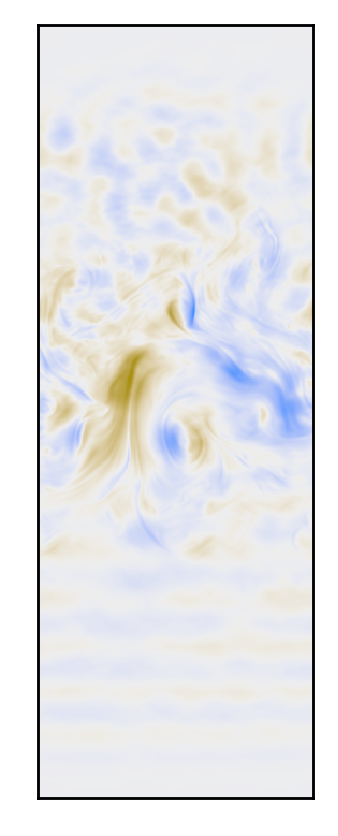

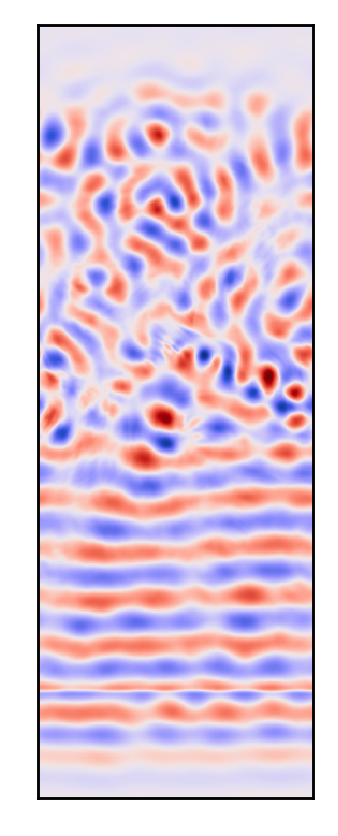

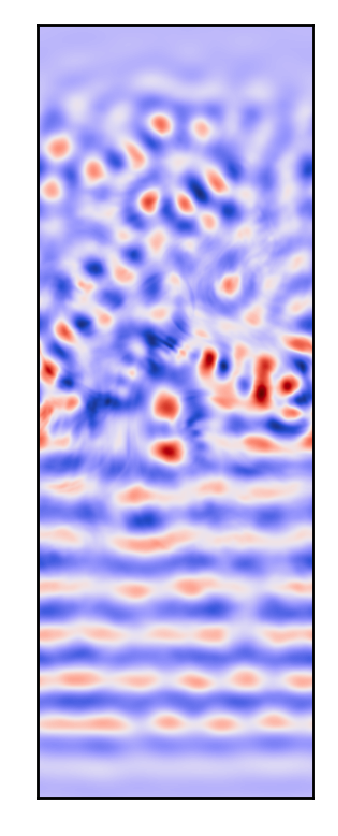

In [7]:
#Plots for the U-Net schematic
fig,axsnapshot = plt.subplots(dpi=256)
axsnapshot.pcolor(inp_H_100, cmap=TOTssh_cmap)
axsnapshot.set_xticks([])
axsnapshot.set_yticks([])
axsnapshot.set_aspect(1)
fig.savefig(figfolder+'in_1.png', bbox_inches='tight',dpi = 256)

fig,axsnapshot = plt.subplots(dpi=256)
axsnapshot.pcolor(inp_T_100, cmap=sst_cmap)
axsnapshot.set_xticks([])
axsnapshot.set_yticks([])
axsnapshot.set_aspect(1)
fig.savefig(figfolder+'in_2.png', bbox_inches='tight',dpi = 256)

fig,axsnapshot = plt.subplots(dpi=256)
axsnapshot.pcolor(U, cmap=vel_cmap)
axsnapshot.set_xticks([])
axsnapshot.set_yticks([])
axsnapshot.set_aspect(1)
fig.savefig(figfolder+'in_3.png', bbox_inches='tight',dpi = 256)

fig,axsnapshot = plt.subplots(dpi=256)
axsnapshot.pcolor(V, cmap=vel_cmap)
axsnapshot.set_xticks([])
axsnapshot.set_yticks([])
axsnapshot.set_aspect(1)
fig.savefig(figfolder+'in_4.png', bbox_inches='tight',dpi = 256)

fig,axsnapshot = plt.subplots(dpi=256)
axsnapshot.pcolor(true_snap, cmap=ITssh_cmap)
axsnapshot.set_xticks([])
axsnapshot.set_yticks([])
axsnapshot.set_aspect(1)
fig.savefig(figfolder+'out_1.png', bbox_inches='tight',dpi = 256)

fig,axsnapshot = plt.subplots(dpi=256)
axsnapshot.pcolor(out_test[ind,1, :, :], cmap=ITssh_cmap)
axsnapshot.set_xticks([])
axsnapshot.set_yticks([])
axsnapshot.set_aspect(1)
fig.savefig(figfolder+'out_2.png', bbox_inches='tight',dpi = 256)
